In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1153).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (352).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (179).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (672).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (501).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (405).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (436).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (883).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (564).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (936).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (837).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (421).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1031).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (221).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVI

/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (230).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (1195).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (182).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (817).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (631).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (369).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (777).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (1249).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (366).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (1139).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (152).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (179).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (1004).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (297).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (1219).png
/kaggle/input/sarscov2-ctscan-dataset/COVID/Covid (556).png
/kaggle/input/sarscov2-ctscan-datas

Neural Network mini-project

This project is done as part of the course at National Institute of Technology Silchar (NITS). In this notebook we will be analyzing the sarscov2-ctscan-dataset using Simple Convolutional Neural Network architechture.

Loading dependencies

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from keras.utils import plot_model
from keras import models
from keras import layers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,LambdaCallback
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score, confusion_matrix

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image

DataFrame Ready

Make a dataframe which we make from the images dataset available .
Covisd and non covid datasets combined. 

In [3]:
data_all = []
disease_class = ['COVID','non-COVID']
data_input_directory = '../input/sarscov2-ctscan-dataset/'
directory = os.path.join(data_input_directory)

for id, sp in enumerate(disease_class):
    for file in os.listdir(os.path.join(directory, sp)):
        data_all.append(['{}/{}'.format(sp, file), id, sp])
         
all_data = pd.DataFrame(data_all, columns=['Image', 'Disease_ID','disease_class'])       

In [4]:
all_data.head()

,Image,Disease_ID,disease_class
0,COVID/Covid (230).png,0,COVID
1,COVID/Covid (1195).png,0,COVID
2,COVID/Covid (182).png,0,COVID
3,COVID/Covid (817).png,0,COVID
4,COVID/Covid (631).png,0,COVID


Randomise the dataset before split it into train, test and validation data

In [5]:
#make the order of training set randomize
SEED = 42
all_data = all_data.sample(frac=1, random_state=SEED)
all_data.index = np.arange(len(all_data))

In [6]:
print(len(all_data))
print(all_data.head())

2481
                           Image  Disease_ID disease_class
0           COVID/Covid (54).png           0         COVID
1         COVID/Covid (1035).png           0         COVID
2   non-COVID/Non-Covid (21).png           1     non-COVID
3  non-COVID/Non-Covid (248).png           1     non-COVID
4          COVID/Covid (409).png           0         COVID


The combine data count, resizing the images and assign X and y columns 

In [7]:
def read_image(filepath):
    return cv2.imread(os.path.join(directory, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [8]:
IMAGE_SIZE = 64
X = np.zeros((all_data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(all_data['Image'].values), total = len(all_data)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.
y = all_data['Disease_ID'].values
print(X.shape)
print(y.shape)

  0%|          | 0/2481 [00:00<?, ?it/s]

(2481, 64, 64, 3)
(2481,)


Spitting the data into train, test and validation data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [10]:
print(X_train.shape)
print(X_test.shape)
print('--------------------')
print(y_train.shape)
print(y_test.shape)
#print('--------------------')
#print(X_val.shape)
#print(y_val.shape)

(1984, 64, 64, 3)
(497, 64, 64, 3)
--------------------
(1984,)
(497,)


In [11]:
#getting ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1)) in the model, this is a trial fix
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [12]:
print(X_train.shape)
print(X_test.shape)
print('--------------------')
print(y_train.shape)
print(y_test.shape)


(1984, 64, 64, 3)
(497, 64, 64, 3)
--------------------
(1984, 1)
(497, 1)


In [13]:
# Create a model and add layers
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(64, 64, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(528, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(Dense(1, activation="sigmoid"))

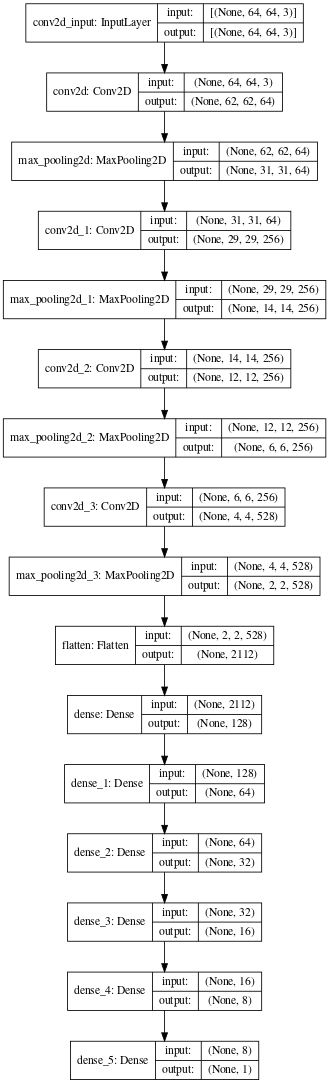

In [14]:
plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 60)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 528)         1

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=64, epochs=30,
                    verbose=1,validation_split=0.2)

Epoch 1/30
13/13 [==============================] - 33s 2s/step - loss: 0.6934 - accuracy: 0.5030 - val_loss: 0.6928 - val_accuracy: 0.5718
Epoch 2/30
13/13 [==============================] - 31s 2s/step - loss: 0.6924 - accuracy: 0.5269 - val_loss: 0.6832 - val_accuracy: 0.7481
Epoch 3/30
13/13 [==============================] - 31s 2s/step - loss: 0.6819 - accuracy: 0.6025 - val_loss: 0.6877 - val_accuracy: 0.4861
Epoch 4/30
13/13 [==============================] - 30s 2s/step - loss: 0.6406 - accuracy: 0.6127 - val_loss: 0.5708 - val_accuracy: 0.7053
Epoch 5/30
13/13 [==============================] - 31s 2s/step - loss: 0.5801 - accuracy: 0.7040 - val_loss: 0.5619 - val_accuracy: 0.7128
Epoch 6/30
13/13 [==============================] - 31s 2s/step - loss: 0.5977 - accuracy: 0.6957 - val_loss: 0.5944 - val_accuracy: 0.6952
Epoch 7/30
13/13 [==============================] - 31s 2s/step - loss: 0.5642 - accuracy: 0.7195 - val_loss: 0.5610 - val_accuracy: 0.7406
Epoch 8/30
13/13 [==

In [17]:
y_pred = model.predict_classes(X_test)
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


16/16 [==============================] - 2s 135ms/step - loss: 0.3040 - accuracy: 0.8994
Final Loss: 0.30397412180900574, Final Accuracy: 0.8993963599205017


In [18]:
true_negative, false_Positive, false_negative, true_Positive = confusion_matrix(y_test, y_pred).ravel()

In [19]:
#print('y_test length = {}'. format(len(y_test)))
print('true_Positive = {}'.format(true_Positive))
print('true_negative = {}'.format(true_negative))
print('false_Positive = {}'.format(false_Positive))
print('false_negative = {}'.format(false_negative))

true_Positive = 231
true_negative = 216
false_Positive = 43
false_negative = 7


In [20]:
Specificity = true_negative/(true_negative+false_Positive)
Sensitivity = true_Positive/(true_Positive+false_negative)

print('f1 score =  %.3f'%f1_score(y_test, y_pred))
print('Precision =  %.3f'%precision_score(y_test, y_pred))
print('Specificity =  %.3f'%Specificity)
print('Sensitivity =  %.3f'%Sensitivity)

f1 score =  0.902
Precision =  0.843
Specificity =  0.834
Sensitivity =  0.971


In [21]:
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(X_train)
    test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(X_test, y_pred)
  # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = LambdaCallback(on_epoch_end=log_confusion_matrix)

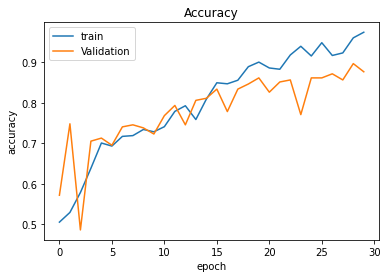

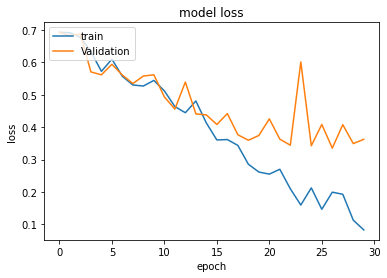

In [22]:
#accuracy and loss plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()


#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [23]:
# Save neural network structure
model_structure = model.to_json()
f = Path("model_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
model.save_weights("model_weights.h5")